<a href="https://colab.research.google.com/github/Banafshehkh/Natural-Language-Processing/blob/main/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Author: Banafsheh Khazali
# Date: March 01, 2023

# **Semantic Text Similarity on Medical Symptoms** 


In [37]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [45]:
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os
import csv

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

## **Scraping the data**

To scrape the data, We can use Python libraries such as BeautifulSoup and requests. 



In [23]:
# Define the URL of the symptom checker page
url = 'https://www.mayoclinic.org/symptom-checker/select-symptom/itt-20009075'

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the section of the page that contains adult symptoms
adult_symptoms_section = soup.find('div', {'class': 'adult'})
# Check that the adult symptoms section was found
if adult_symptoms_section:
    # Find all links within the adult symptoms section
    adult_symptom_links = adult_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    adult_symptom_urls = [link['href'] for link in adult_symptom_links]

    


# Find the section of the page that contains child symptoms
child_symptoms_section = soup.find('div', {'class': 'child'})

# Check that the child symptoms section was found
if child_symptoms_section:
    # Find all links within the child symptoms section
    child_symptom_links = child_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    child_symptom_urls = [link['href'] for link in child_symptom_links]



# Print the URLs for the adult symptoms
full_adult_url = []
for i in adult_symptom_urls:
  full_adult_url.append("https://www.mayoclinic.org/"+i)

print('\nAdult Symptom URLs:', full_adult_url)

# Print the URLs for the child symptoms
full_child_urls = []
for i in child_symptom_urls:
  full_child_urls.append("https://www.mayoclinic.org/"+i)

print('\nChild Symptom URLs:', full_child_urls)



Adult Symptom URLs: ['https://www.mayoclinic.org//symptom-checker/abdominal-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/blood-in-stool-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/chest-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/constipation-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/cough-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/diarrhea-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/difficulty-swallowing-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/dizziness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/eye-discomfort-and-redness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclini

**extract adult symptoms**

In [30]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_adult_url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    adult_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if adult_symptoms_section is not None:
        filename = f'adult_page{i+1}.txt'
        with open(filename, 'w') as f:
            f.write(adult_symptoms_section.text)
    else:
        print(f"No 'adult' section found on page {i+1}")

No 'adult' section found on page 4
No 'adult' section found on page 14
No 'adult' section found on page 16
No 'adult' section found on page 18
No 'adult' section found on page 19
No 'adult' section found on page 22
No 'adult' section found on page 24


**extract children symptoms**

In [31]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_child_urls):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    child_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if child_symptoms_section is not None:
        filename = f'child_page{i+1}.txt'
        with open(filename, 'w') as f:
            f.write(child_symptoms_section.text)
    else:
        print(f"No 'child' section found on page {i+1}")

No 'child' section found on page 2
No 'child' section found on page 3
No 'child' section found on page 4
No 'child' section found on page 9
No 'child' section found on page 12
No 'child' section found on page 13
No 'child' section found on page 15


## **Preprocessing the data**

To preprocess the data, We may need to clean and tokenize the text, remove stop words, and perform stemming or lemmatization.

In [33]:
!mkdir adult

In [34]:
!mkdir children

**Preprocess adult files**

In [38]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return lemmatized_tokens

# Define the directory where the text files are located
adult_dir_in = '/content/adult'
adult_dir_out = '/content/adult/pre_adult'

# Create the output directory if it doesn't exist
if not os.path.exists(adult_dir_out):
    os.makedirs(adult_dir_out)


# Loop over the input files
for filename in os.listdir(adult_dir_in):
    if filename.endswith('.txt'):
        # Read the input file
        with open(os.path.join(adult_dir_in, filename), 'r') as f:
            text = f.read()
        
        # Preprocess the text
        tokens = word_tokenize(text.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        preprocessed_text = ' '.join(lemmatized_tokens)
        
        # Write the preprocessed text to a new file
        output_filename = os.path.join(adult_dir_out, filename)
        with open(output_filename, 'w') as f:
            f.write(preprocessed_text)
            
        print(f'Processed file: {filename}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed file: adltu_page2.txt
Processed file: adltu_page1.txt


**Preprocess children files**

In [40]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return lemmatized_tokens

# Define the directory where the text files are located
child_dir_in = '/content/children'
child_dir_out = '/content/children/pre_child'

# Create the output directory if it doesn't exist
if not os.path.exists(child_dir_out):
    os.makedirs(child_dir_out)


# Loop over the input files
for filename in os.listdir(child_dir_in):
    if filename.endswith('.txt'):
        # Read the input file
        with open(os.path.join(child_dir_in, filename), 'r') as f:
            text = f.read()
        
        # Preprocess the text
        tokens = word_tokenize(text.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        preprocessed_text = ' '.join(lemmatized_tokens)
        
        # Write the preprocessed text to a new file
        output_filename = os.path.join(child_dir_out, filename)
        with open(output_filename, 'w') as f:
            f.write(preprocessed_text)
            
        print(f'Processed file: {filename}')

Processed file: child_page17.txt
Processed file: child_page16.txt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Calculating the similarity**

Calculate the similarity between the two document-term matrices using a similarity metric such as cosine similarity or Jaccard similarity.

In [44]:
# Define directory path containing text files
dir_path = '/content/children/pre_child'

# Get all text files in directory
file_names = [f for f in os.listdir(dir_path) if f.endswith('.txt')]

# Read contents of each text file and store in a list
corpus = []
for file_name in file_names:
    with open(os.path.join(dir_path, file_name), 'r') as f:
        text = f.read()
        corpus.append(text)

# Calculate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Compute cosine similarity between all documents
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print similarity matrix.                                                                                                                                                                                                                                                                                     
print(similarity_matrix)

[[1.         0.89039445]
 [0.89039445 1.        ]]


##  Visualize the similarity results using a heatmap or a dendrogram

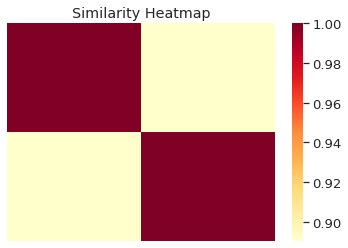

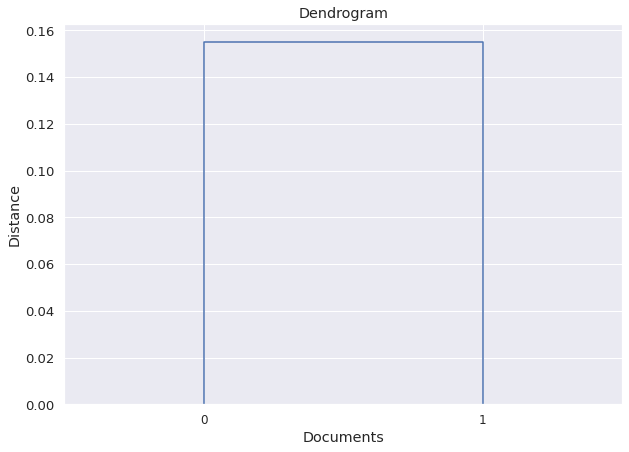

In [46]:
# Create heatmap
sns.set(font_scale=1.2)
sns.heatmap(similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Similarity Heatmap')
plt.show()

# Create dendrogram
plt.figure(figsize=(10, 7))
dendrogram = hierarchy.dendrogram(hierarchy.linkage(similarity_matrix, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Documents')
plt.ylabel('Distance')
plt.show()